# Further process the HI4PI image
## This notebook creates a smoother, lower resolution image of the Milky Way.

These new images are created to compare with horn radio telescope images.

Glen Langston - NSF - 2022 January 11

First run python commands with already installed code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

from astropy.utils import data
data.conf.remote_timeout = 60
import radio_beam


Upload the Bonn HI4PI cube with 1.5degree resolution

In [2]:
# This notebook assumes you've created a trimed equitorial coordiante sky image
filename = "hi4pi-eq-trim.fits"
#!wget {fullpath}

    

In [3]:
# install the cube and projection code
from spectral_cube import SpectralCube

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

Created TAP+ (v20200428.1) - Connection:
	Host: sky.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [4]:
allsky = filename
# or
# allsky = "/dlusers/glangsto/" + allsky
hi_data = fits.open(allsky)  # Open the FITS file for reading
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCubecube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
allsky = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close()  # Close the FITS file - we already read it in and don't need it anymore!

In [5]:
print(cube)

SpectralCube with shape=(311, 361, 721) and unit=K:
 n_x:    721  type_x: RA---CAR  unit_x: deg    range:   180.000000 deg:  180.000000 deg
 n_y:    361  type_y: DEC--CAR  unit_y: deg    range:   -90.000000 deg:   90.000000 deg
 n_s:    311  type_s: VRAD      unit_s: m / s  range:  -199572.363 m / s:  199774.278 m / s


Now take a look at one velocity channel of the cube

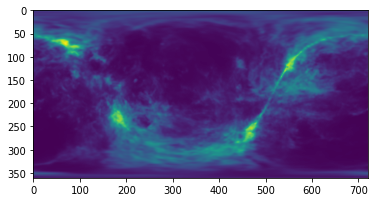

In [6]:
# get the cube dimensions and middles of each axis
ns = cube.shape[0]
nx = cube.shape[1]
ny = cube.shape[2]
ns2 = int(ns/2)
nx2 = int(nx/2)
ny2 = int(ny/2)
cube[ns2, :, :].quicklook()  # Slice the cube along the spectral axis, and display a quick image

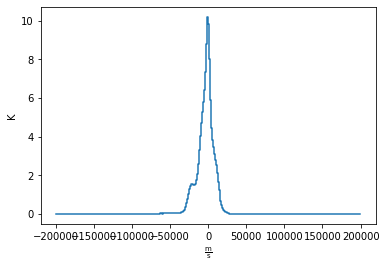

In [7]:
cube[:, nx2, ny2].quicklook()  # Extract a single spectrum through the data cube

In [48]:
# now to prepare to get RA, Dec coordiante

In [8]:
_, ra, _ = cube.world[0, :, 0]  #extract latitude world coordinates from cube
_, _, dec = cube.world[0, 0, :]  #extract longitude world coordinates from cube

In [9]:
# get the world coordinate system parameters of this cube
wcs=WCS(cube.header)
print(wcs)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---CAR'  'DEC--CAR'  'VRAD'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 361.0  181.0  155.9216300032  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.5  0.5  1288.2149691242  
NAXIS : 721  361  311


In [10]:
degree = 3600.*u.arcsec
# decrease the angular resolution.  4 degrees in this example
hornbeam = 4 * degree
beam = radio_beam.Beam(major=hornbeam, minor=hornbeam, pa=0*u.deg)
sub_cube = cube.convolve_to(beam)

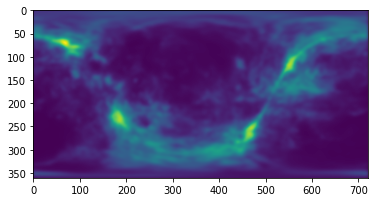

In [12]:
sub_cube[ ns2, :, :].quicklook() 

In [26]:
#moment_0 = sub_cube.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment
moment_0 = sub_cube.moment(order=0)  # Zero-th moment
#moment_1 = sub_cube.with_spectral_unit(u.km/u.s).moment(order=1)  # First moment
moment_1 = sub_cube.moment(order=1)  # First moment

# Write the moments as a FITS image
# moment_0.write('hi_moment_0.fits')
# moment_1.write('hi_moment_1.fits')

print('Moment_0 has units of: ', moment_0.unit)
print('Moment_1 has units of: ', moment_1.unit)

# Convert Moment_0 to a Column Density assuming optically thin media
hi_column_density = moment_0 * 1.82 * 10**15 / (u.cm * u.cm) * u.s / u.K / u.km

Moment_0 has units of:  K m / s
Moment_1 has units of:  m / s


In [27]:
print(moment_1.wcs)  # Examine the WCS object associated with the moment map

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---CAR'  'DEC--CAR'  
CRVAL : 0.0  0.0  
CRPIX : 361.0  181.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.5  0.5  
NAXIS : 0  0


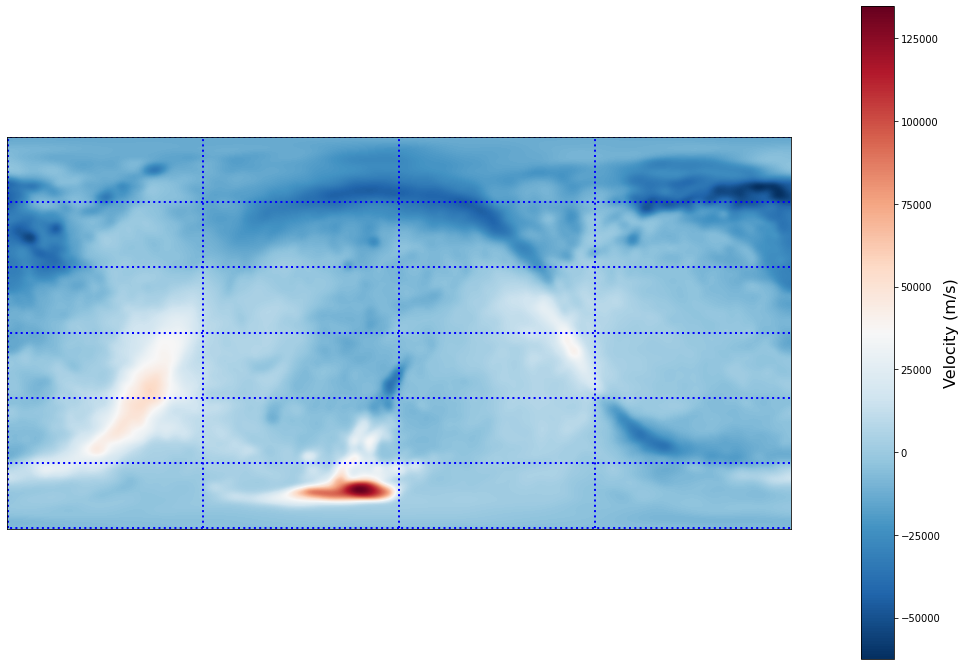

In [28]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# Display the moment map image
#im = ax.imshow(moment_0.hdu.data, cmap='RdBu_r', vmin=-50, vmax=50)

im = ax.imshow(moment_1.hdu.data, cmap='RdBu_r')

#ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("Right Ascension (degrees)", fontsize=16)
ax.set_ylabel("Declination (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (m/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='blue', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours
#levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
#ax.contour(hi_column_density.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

## Display the intensity map.  
### As expected, the strongest emission is in the Galactic Plane

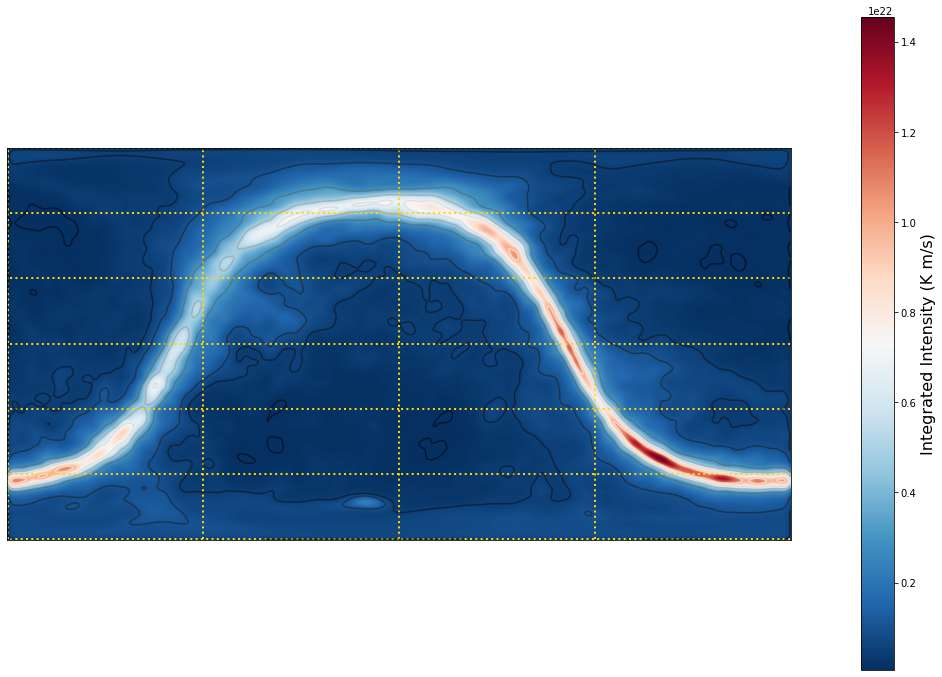

In [30]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_0.wcs)

# Display the moment map image
im = ax.imshow(hi_column_density.hdu.data, cmap='RdBu_r')
#ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("Right Ascension (degrees)", fontsize=16)
ax.set_ylabel("Declination (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Integrated Intensity (K m/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='gold', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

In [31]:
## Write the column density
outname="hi4pi-column-density.fits"
hi_column_density.write(outname)

# Congratuations!

## You've read in an all-sky FITS image of the Milky Way Galaxy and smoothed the image to more closely match your horn radio telescope observations